In [2]:
#Import Libraries 
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from glob import glob
from numpy import genfromtxt
import seaborn as sns
import matplotlib.pyplot as plt

tf.random.set_seed(1234)

In [3]:
#Constants
NUM_POINTS = 5000
NUM_CLASSES = 4
BATCH_SIZE = 64
NUM_EPOCHS = 15

In [4]:
#Import Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
# reads and returns the data from google drive  
def readData(filename, dtype=float):
    def openFile():
        with open(filename, 'r') as f:
            for line in f:
                line = line.rstrip().split(',')
                for elm in line:
                    yield dtype(elm)
        readData.length = len(line)

    d = np.fromiter(openFile(), dtype=dtype)
    d = d.reshape((-1, readData.length))
    return d

In [8]:
# read contents into dataUpSampled, train_labels variables
dataUpSampled = readData('/content/gdrive/My Drive/best2ndData5k4Classes.csv').reshape((-1,NUM_POINTS, 3))

train_labels = readData('/content/gdrive/My Drive/best2ndLabels5k4Classes.csv') 

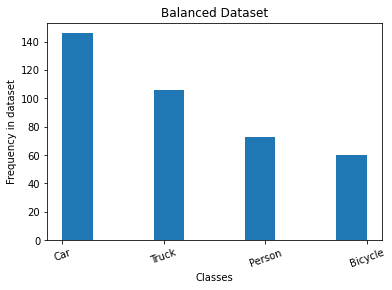

In [32]:
#histogram containing class counts
plt.hist(train_labels)
plt.title("Balanced Dataset")
plt.xlabel("Classes")
plt.ylabel("Frequency in dataset")
plt.xticks([0, 1, 2, 3], ['Car', 'Truck', 'Person', 'Bicycle'], rotation=20)
plt.show()

In [9]:
# randomly split the data into testing and training
from sklearn.model_selection import train_test_split
import random 

temp = list(zip(dataUpSampled, train_labels))
random.shuffle(temp)
x_shuffled, y_shuffled = zip(*temp)

training_data, testing_data, training_label, testing_label = train_test_split(x_shuffled, y_shuffled, test_size=0.45, shuffle=False)

In [11]:
#shuffle the data
lower, upper =  -0.0075, 0.0075
def shuffleData(points, label):
    points += tf.random.uniform(points.shape, lower, upper, dtype=tf.float64)
    points = tf.random.shuffle(points)
    return points, label
    
td = tf.data.Dataset.from_tensor_slices((np.array(training_data), training_label))
train_dataset = td.shuffle(211).map(shuffleData).batch(BATCH_SIZE)

td = tf.data.Dataset.from_tensor_slices((np.array(testing_data), testing_label))
test_dataset = td.shuffle(174).map(shuffleData).batch(BATCH_SIZE)

In [25]:
# Define regularizer class 
class orthoReg(keras.regularizers.Regularizer):
    def __init__(self, n):
      self.n = n

    def __call__(self, x):
      x = tf.reshape(x, (-1, self.n, self.n))
      xsquaredt = tf.reshape(tf.tensordot(x, x, axes=(2, 2)), (-1, self.n, self.n))
      squaredDifference = tf.square(xsquaredt - tf.eye(self.n))
      return tf.reduce_sum(0.001 * squaredDifference)

#define tnet layer for model
def tNetLayer(inputs, n):
    activationFunction = "relu"
    padding, epsilon, momentum, kernel_size = "valid", 0.001, 0, 1
    x = layers.Conv1D(32, kernel_size=kernel_size, padding=padding)(inputs)
    x = layers.BatchNormalization(momentum=momentum, epsilon=epsilon)(x)
    x = layers.Activation(activationFunction)(x)
    x = layers.Conv1D(64, kernel_size=kernel_size, padding=padding)(x)
    x = layers.BatchNormalization(momentum=momentum, epsilon=epsilon)(x)
    x = layers.Activation(activationFunction)(x)
    x = layers.Conv1D(512, kernel_size=kernel_size, padding=padding)(x)
    x = layers.BatchNormalization(momentum=momentum, epsilon=epsilon)(x)
    x = layers.Activation(activationFunction)(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization(momentum=momentum, epsilon=epsilon)(x)
    x = layers.Activation(activationFunction)(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization(momentum=momentum, epsilon=epsilon)(x)
    x = layers.Activation(activationFunction)(x)
    x = layers.Dense(n * n, kernel_initializer="zeros",
        bias_initializer=keras.initializers.Constant(np.eye(n).flatten()), 
        activity_regularizer=orthoReg(n))(x)
    x = layers.Reshape((n, n))(x)
    return layers.Dot(axes=(2, 1))([inputs, x])

#define full model architecture 
def initalizeModel(dropOutVal, denseActivationFunc="softmax"):
  activationFunction = "relu"
  padding, epsilon, momentum, kernel_size = "valid", 0.001, 0, 1
  feed = keras.Input(shape=(NUM_POINTS, 3))
  x = tNetLayer(feed, 3)
  x = layers.Conv1D(32, kernel_size=kernel_size, padding=padding)(x)
  x = layers.BatchNormalization(momentum=momentum, epsilon=epsilon)(x)
  x = layers.Activation(activationFunction)(x)
  x = tNetLayer(x, 32)
  x = layers.Conv1D(32, kernel_size=kernel_size, padding=padding)(x)
  x = layers.BatchNormalization(momentum=momentum, epsilon=epsilon)(x)
  x = layers.Activation(activationFunction)(x)
  x = layers.Conv1D(64, kernel_size=kernel_size, padding=padding)(x)
  x = layers.BatchNormalization(momentum=momentum, epsilon=epsilon)(x)
  x = layers.Activation(activationFunction)(x)
  x = layers.Conv1D(128, kernel_size=kernel_size, padding=padding)(x)
  x = layers.BatchNormalization(momentum=momentum, epsilon=epsilon)(x)
  x = layers.Activation(activationFunction)(x)
  x = layers.Conv1D(512, kernel_size=kernel_size, padding=padding)(x)
  x = layers.BatchNormalization(momentum=momentum, epsilon=epsilon)(x)
  x = layers.Activation(activationFunction)(x)
  x = layers.Conv1D(1024, kernel_size=kernel_size, padding=padding)(x)
  x = layers.BatchNormalization(momentum=momentum, epsilon=epsilon)(x)
  x = layers.Activation(activationFunction)(x)
  x = layers.GlobalMaxPooling1D()(x)
  x = layers.Dense(256)(x)
  x = layers.BatchNormalization(momentum=momentum, epsilon=epsilon)(x)
  x = layers.Activation(activationFunction)(x)
  x = layers.Dropout(dropOutVal)(x)
  x = layers.Dense(128)(x)
  x = layers.BatchNormalization(momentum=momentum, epsilon=epsilon)(x)
  x = layers.Activation(activationFunction)(x)
  x = layers.Dropout(dropOutVal)(x)
  res = layers.Dense(NUM_CLASSES, activation=denseActivationFunc)(x)
  model = keras.Model(feed, res)
  return model

In [26]:
# testing different learning rate values
model = initalizeModel(.5, activationFunc="softmax")
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(train_dataset, epochs=1, validation_data=test_dataset)

4/4 [==============================] - 141s 32s/step - loss: 5.9791 - sparse_categorical_accuracy: 0.2332 - val_loss: 50.0147 - val_sparse_categorical_accuracy: 0.5747


In [33]:
# testing different learning rate values
model = initalizeModel(.5, activationFunc="softmax")
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
5/5 [==============================] - 8s 851ms/step - loss: 5.5663 - sparse_categorical_accuracy: 0.4061 - val_loss: 4.1144 - val_sparse_categorical_accuracy: 0.7403
Epoch 2/100
5/5 [==============================] - 4s 725ms/step - loss: 4.0749 - sparse_categorical_accuracy: 0.6717 - val_loss: 2.8314 - val_sparse_categorical_accuracy: 0.8442
Epoch 3/100
5/5 [==============================] - 4s 729ms/step - loss: 3.2739 - sparse_categorical_accuracy: 0.7116 - val_loss: 3.3376 - val_sparse_categorical_accuracy: 0.7922
Epoch 4/100
5/5 [==============================] - 4s 727ms/step - loss: 2.8599 - sparse_categorical_accuracy: 0.7853 - val_loss: 3.2619 - val_sparse_categorical_accuracy: 0.8312
Epoch 5/100
5/5 [==============================] - 4s 728ms/step - loss: 2.7186 - sparse_categorical_accuracy: 0.8571 - val_loss: 2.3436 - val_sparse_categorical_accuracy: 0.8052
Epoch 6/100
5/5 [==============================] - 4s 730ms/step - loss: 2.5625 - sparse_categorical_accu

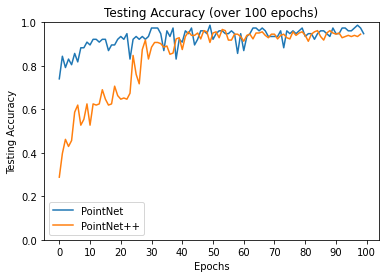

In [53]:
#got this array from my other notebook

pointnetpluslusacc = [0.28804348, 0.39673913, 0.46195652, 0.42934783, 0.45652174,
       0.58695652, 0.61956522, 0.52717391, 0.55434783, 0.625     ,
       0.52717391, 0.625     , 0.61956522, 0.625     , 0.69021739,
       0.64673913, 0.61956522, 0.625     , 0.70652174, 0.66304348,
       0.64673913, 0.65217391, 0.64673913, 0.67391304, 0.84782609,
       0.76086957, 0.7173913 , 0.875     , 0.91847826, 0.83152174,
       0.88586957, 0.9076087 , 0.9076087 , 0.90217391, 0.88586957,
       0.89130435, 0.85326087, 0.85869565, 0.92391304, 0.92934783,
       0.875     , 0.93478261, 0.95652174, 0.94021739, 0.94021739,
       0.95108696, 0.92391304, 0.96195652, 0.95652174, 0.9076087 ,
       0.95108696, 0.95652174, 0.92934783, 0.9673913 , 0.96195652,
       0.91847826, 0.91847826, 0.94565217, 0.94565217, 0.93478261,
       0.91304348, 0.94021739, 0.94565217, 0.92391304, 0.95108696,
       0.95108696, 0.95652174, 0.94021739, 0.92934783, 0.94565217,
       0.94565217, 0.92391304, 0.94021739, 0.94565217, 0.92934783,
       0.92391304, 0.95652174, 0.94021739, 0.95108696, 0.95652174,
       0.94021739, 0.91304348, 0.94565217, 0.95652174, 0.96195652,
       0.93478261, 0.91847826, 0.95108696, 0.96195652, 0.95108696,
       0.94565217, 0.95108696, 0.92934783, 0.93478261, 0.94021739,
       0.93478261, 0.94021739, 0.93478261, 0.94565217]

#plot 100 epoch accuracies 

plt.plot(list(history.history['val_sparse_categorical_accuracy']), label = "PointNet")
plt.plot(pointnetpluslusacc, label = "PointNet++")
plt.title("Testing Accuracy (over 100 epochs)")
plt.xlabel("Epochs")
plt.ylabel("Testing Accuracy")
plt.legend()
plt.ylim((0, 1))
plt.xticks(np.arange(0,110,10))
plt.show()

In [84]:
#returns argmax of array
def getPred(arr):
    maxVal, maxIndex = 0, 0
    for i in range(len(arr)):
        if arr[i] > maxVal:
            maxVal = arr[i]
            maxIndex = i
    return maxIndex

#calculates error percentage 
def getTestingAccuracy(model):
  correct = []
  guesses = []
  err = 0
  for i in range(len(testing_label)):
    pre = testing_data[i].reshape((1,NUM_POINTS,3))
    prediction = getPred(model.predict(pre)[0] )
    guesses.append(prediction)
    corr_answer = testing_label[i]
    correct.append(corr_answer[0])
    if prediction != corr_answer[0]:
      err += 1
  print(1-err/len(testing_label))
  return correct, guesses

In [47]:
#maps between class labels and actual class
CLASS_MAP = {
    'vans': 0,
    'cars': 1,
    'people': 2,
    'bic': 3
}

Epoch 1/10
5/5 [==============================] - 8s 843ms/step - loss: 5.8895 - sparse_categorical_accuracy: 0.3300 - val_loss: 4.7334 - val_sparse_categorical_accuracy: 0.4805
Epoch 2/10
5/5 [==============================] - 4s 719ms/step - loss: 5.3274 - sparse_categorical_accuracy: 0.4525 - val_loss: 4.3150 - val_sparse_categorical_accuracy: 0.5844
Epoch 3/10
5/5 [==============================] - 4s 724ms/step - loss: 4.9885 - sparse_categorical_accuracy: 0.5262 - val_loss: 4.1091 - val_sparse_categorical_accuracy: 0.6234
Epoch 4/10
5/5 [==============================] - 4s 724ms/step - loss: 4.8423 - sparse_categorical_accuracy: 0.5924 - val_loss: 3.8091 - val_sparse_categorical_accuracy: 0.8831
Epoch 5/10
5/5 [==============================] - 4s 724ms/step - loss: 4.5333 - sparse_categorical_accuracy: 0.6444 - val_loss: 3.6225 - val_sparse_categorical_accuracy: 0.8442
Epoch 6/10
5/5 [==============================] - 4s 722ms/step - loss: 4.2311 - sparse_categorical_accuracy: 

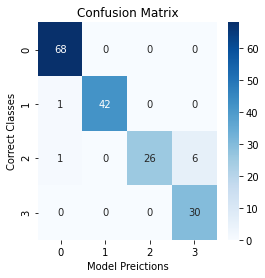

In [55]:
model = initalizeModel(.5, activationFunc="softmax")
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["sparse_categorical_accuracy"],
)
model.fit(train_dataset, epochs=10, validation_data=test_dataset)

# generate confusion matrix
def generateConfusionMatrix(correct, guess):
  matrix = tf.math.confusion_matrix(correct, guess)
  fig, ax = plt.subplots(figsize=(4,4))         # Sample figsize in inches
  sns.heatmap(matrix, annot=True, cmap='Blues', xticklabels=CLASS_MAP.values(), yticklabels=CLASS_MAP.values())
  ax.set_xlabel("Model Preictions")
  ax.set_ylabel("Correct Classes")
  ax.set_title("Confusion Matrix")
  plt.show()

correct, guesses = getTestingAccuracy(model)
generateConfusionMatrix(correct, guesses)

## Experiments Below


In [14]:
# testing different learning rate values
model = initalizeModel(.5, activationFunc="softmax")
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["sparse_categorical_accuracy"],
)
model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/15
5/5 [==============================] - 8s 897ms/step - loss: 5.8221 - sparse_categorical_accuracy: 0.3098 - val_loss: 4.6104 - val_sparse_categorical_accuracy: 0.4805
Epoch 2/15
5/5 [==============================] - 4s 720ms/step - loss: 5.5252 - sparse_categorical_accuracy: 0.3810 - val_loss: 4.2386 - val_sparse_categorical_accuracy: 0.7922
Epoch 3/15
5/5 [==============================] - 4s 723ms/step - loss: 5.0939 - sparse_categorical_accuracy: 0.5002 - val_loss: 4.0574 - val_sparse_categorical_accuracy: 0.8312
Epoch 4/15
5/5 [==============================] - 4s 725ms/step - loss: 4.7747 - sparse_categorical_accuracy: 0.5692 - val_loss: 3.7271 - val_sparse_categorical_accuracy: 0.8571
Epoch 5/15
5/5 [==============================] - 4s 725ms/step - loss: 4.5006 - sparse_categorical_accuracy: 0.6364 - val_loss: 3.5266 - val_sparse_categorical_accuracy: 0.9091
Epoch 6/15
5/5 [==============================] - 4s 726ms/step - loss: 4.3576 - sparse_categorical_accuracy: 

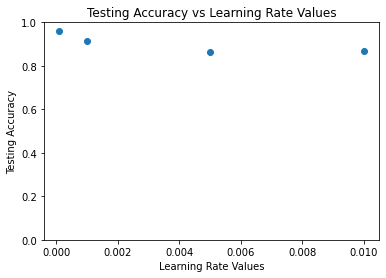

In [16]:
#collected testing accuries for dirrect learning rate values from above
#ran for 10 epochs
lr_vals = [0.0001,0.001,0.005, 0.01]
final_test_accuries = [0.9610, .9121, .8651, 0.8701]

plt.scatter(x=lr_vals, y=final_test_accuries)
plt.title("Testing Accuracy vs Learning Rate Values")
plt.xlabel("Learning Rate Values")
plt.ylabel("Testing Accuracy")
plt.ylim((0, 1))
plt.xticks(np.arange(0,0.01 + .002, .002))
plt.show()

In [18]:
# testing different learning rate values
model = initalizeModel(.25, activationFunc="softmax")
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["sparse_categorical_accuracy"],
)
model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/15
5/5 [==============================] - 8s 851ms/step - loss: 5.7143 - sparse_categorical_accuracy: 0.2755 - val_loss: 4.3967 - val_sparse_categorical_accuracy: 0.6753
Epoch 2/15
5/5 [==============================] - 4s 724ms/step - loss: 5.2400 - sparse_categorical_accuracy: 0.4581 - val_loss: 4.2030 - val_sparse_categorical_accuracy: 0.7662
Epoch 3/15
5/5 [==============================] - 4s 725ms/step - loss: 4.8271 - sparse_categorical_accuracy: 0.6145 - val_loss: 4.0351 - val_sparse_categorical_accuracy: 0.7403
Epoch 4/15
5/5 [==============================] - 4s 727ms/step - loss: 4.5873 - sparse_categorical_accuracy: 0.6615 - val_loss: 3.7034 - val_sparse_categorical_accuracy: 0.8052
Epoch 5/15
5/5 [==============================] - 4s 725ms/step - loss: 4.2310 - sparse_categorical_accuracy: 0.7821 - val_loss: 3.4968 - val_sparse_categorical_accuracy: 0.8571
Epoch 6/15
5/5 [==============================] - 4s 727ms/step - loss: 4.0019 - sparse_categorical_accuracy: 

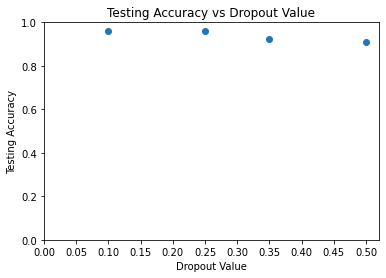

In [21]:
#collected testing accuries for dirrect dropout values from above
dropouts = [.1,.25,.35,.5]
final_test_accuries = [0.9610, .9610, .9221, .9091]

plt.scatter(dropouts, final_test_accuries)
plt.title("Testing Accuracy vs Dropout Value")
plt.xlabel("Dropout Value")
plt.ylabel("Testing Accuracy")
plt.ylim((0, 1))
plt.xticks(np.arange(0,.55,.05))
plt.show()

In [22]:
# testing different learning rate values (RMSprop)
model = initalizeModel(.25, activationFunc="softmax")
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    metrics=["sparse_categorical_accuracy"],
)
model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/15
5/5 [==============================] - 9s 866ms/step - loss: 5.6727 - sparse_categorical_accuracy: 0.3165 - val_loss: 4.4431 - val_sparse_categorical_accuracy: 0.8182
Epoch 2/15
5/5 [==============================] - 4s 730ms/step - loss: 4.7690 - sparse_categorical_accuracy: 0.7387 - val_loss: 3.8548 - val_sparse_categorical_accuracy: 0.8571
Epoch 3/15
5/5 [==============================] - 4s 723ms/step - loss: 4.2533 - sparse_categorical_accuracy: 0.8313 - val_loss: 3.4864 - val_sparse_categorical_accuracy: 0.7922
Epoch 4/15
5/5 [==============================] - 4s 725ms/step - loss: 4.0273 - sparse_categorical_accuracy: 0.8454 - val_loss: 3.1877 - val_sparse_categorical_accuracy: 0.9740
Epoch 5/15
5/5 [==============================] - 4s 726ms/step - loss: 3.7455 - sparse_categorical_accuracy: 0.9011 - val_loss: 3.0558 - val_sparse_categorical_accuracy: 0.8701
Epoch 6/15
5/5 [==============================] - 4s 728ms/step - loss: 3.5387 - sparse_categorical_accuracy: 

In [23]:
# testing different optimizers (SGD)
model = initalizeModel(.25, activationFunc="softmax")
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    metrics=["sparse_categorical_accuracy"],
)
model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/15
5/5 [==============================] - 8s 848ms/step - loss: 5.8948 - sparse_categorical_accuracy: 0.2352 - val_loss: 4.6995 - val_sparse_categorical_accuracy: 0.5325
Epoch 2/15
5/5 [==============================] - 4s 726ms/step - loss: 5.6119 - sparse_categorical_accuracy: 0.3129 - val_loss: 5.0397 - val_sparse_categorical_accuracy: 0.2857
Epoch 3/15
5/5 [==============================] - 4s 726ms/step - loss: 5.5723 - sparse_categorical_accuracy: 0.3324 - val_loss: 4.9565 - val_sparse_categorical_accuracy: 0.3377
Epoch 4/15
5/5 [==============================] - 4s 727ms/step - loss: 5.4064 - sparse_categorical_accuracy: 0.3734 - val_loss: 4.9139 - val_sparse_categorical_accuracy: 0.6623
Epoch 5/15
5/5 [==============================] - 4s 727ms/step - loss: 5.4250 - sparse_categorical_accuracy: 0.3887 - val_loss: 4.5829 - val_sparse_categorical_accuracy: 0.6494
Epoch 6/15
5/5 [==============================] - 4s 727ms/step - loss: 5.3772 - sparse_categorical_accuracy: 

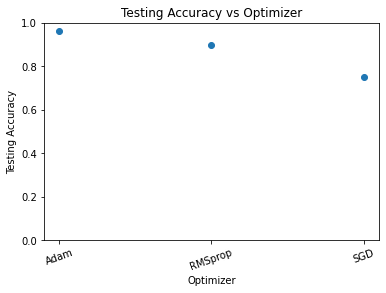

In [58]:
optimizerLabel = ["Adam", "RMSprop", "SGD"]
optimizer_accuracy = [.9610, 0.8961, .7532]
plt.scatter(x=[0,1,2], y=optimizer_accuracy)
plt.title("Testing Accuracy vs Optimizer")
plt.xlabel("Optimizer")
plt.ylabel("Testing Accuracy")
plt.xticks([0, 1, 2], ['Adam', 'RMSprop', 'SGD'], rotation=20)
plt.ylim((0, 1))
plt.show()

In [97]:
# testing different architectures
model = initalizeModel(.25, activationFunc="softmax")
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    metrics=["sparse_categorical_accuracy"],
)
model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/15
5/5 [==============================] - 8s 849ms/step - loss: 5.7763 - sparse_categorical_accuracy: 0.2656 - val_loss: 4.9912 - val_sparse_categorical_accuracy: 0.2857
Epoch 2/15
5/5 [==============================] - 4s 719ms/step - loss: 5.6520 - sparse_categorical_accuracy: 0.3198 - val_loss: 4.8424 - val_sparse_categorical_accuracy: 0.4545
Epoch 3/15
5/5 [==============================] - 4s 715ms/step - loss: 5.5530 - sparse_categorical_accuracy: 0.4178 - val_loss: 4.8339 - val_sparse_categorical_accuracy: 0.4545
Epoch 4/15
5/5 [==============================] - 4s 718ms/step - loss: 5.4220 - sparse_categorical_accuracy: 0.4157 - val_loss: 4.6371 - val_sparse_categorical_accuracy: 0.5195
Epoch 5/15
5/5 [==============================] - 4s 716ms/step - loss: 5.3738 - sparse_categorical_accuracy: 0.3996 - val_loss: 4.5394 - val_sparse_categorical_accuracy: 0.5974
Epoch 6/15
5/5 [==============================] - 4s 716ms/step - loss: 5.3963 - sparse_categorical_accuracy: 

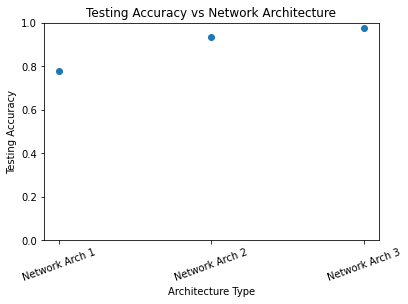

In [101]:
arch_accuracy = [0.7792, 0.9351, 0.9740]
plt.scatter(x=[0,1,2], y=arch_accuracy)
plt.title("Testing Accuracy vs Network Architecture")
plt.xlabel("Architecture Type")
plt.ylabel("Testing Accuracy")
plt.xticks([0, 1, 2], ["Network Arch 1", "Network Arch 2", "Network Arch 3"], rotation=20)
plt.ylim((0, 1))
plt.show()

In [100]:
#table with all the data
experiment_name = ["Dropout Value", "Dropout Value", "Dropout Value", "Dropout Value", 
                   "Learning Rate", "Learning Rate", "Learning Rate", "Learning Rate",
                   "Optimizer", "Optimizer", "Optimizer", "MLP Architecture", "MLP Architecture", "MLP Architecture"]
valTested = [.1,.25,.35,.5,0.0001,0.001,0.005,0.01, "ADAM", "RMSprop", "SGD", "MLP Arch 1", "MLP Arch 2", "MLP Arch 3"]
result_accuracy = [0.9610, .9610, .9221, .9091,0.9610, .9121, .8651, 0.8701,.9610, 0.8961, .7532,0.7792, 0.9351, 0.9740]

d = {'Experiment': experiment_name, 'Value Tested': valTested, 'Accuracy': result_accuracy}
df = pd.DataFrame(data=d)
df

,Experiment,Value Tested,Accuracy
0,Dropout Value,0.1,0.9610
1,Dropout Value,0.25,0.9610
2,Dropout Value,0.35,0.9221
3,Dropout Value,0.5,0.9091
4,Learning Rate,0.0001,0.9610
5,Learning Rate,0.001,0.9121
6,Learning Rate,0.005,0.8651
7,Learning Rate,0.01,0.8701
8,Optimizer,ADAM,0.9610
9,Optimizer,RMSprop,0.8961
